**Nishat Ahmed, Lucia Rhode, Seyun Kim**

In [ ]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import plot_importance
import matplotlib.pyplot as plt
from sklearn.inspection import plot_partial_dependence
from sklearn.inspection import PartialDependenceDisplay
from sklearn.datasets import fetch_california_housing
from sklearn.datasets import fetch_covtype
from sklearn.inspection import partial_dependence
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import accuracy_score
from mpl_toolkits.mplot3d import Axes3D

## **1. California Housing Data Set**

In [ ]:
#load data as pandas dataframe
cal = fetch_california_housing()
df = pd.DataFrame(cal.data, columns=cal.feature_names)
df['target'] = pd.Series(cal.target)
df.head()


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [ ]:
#https://xgboost.readthedocs.io/en/latest/tutorials/model.html

In [ ]:
#check for null values
print(df.isnull().values.any())

False


In [ ]:
#split features and target
X = df[["MedInc", "HouseAge", "AveRooms", "AveBedrms", "Population", "AveOccup", "Latitude", "Longitude"]]
y = df["target"]
#X_test = df[["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_income"]]
#Y_test = df["median_house_value"]

In [ ]:
#check features and target split
print(X.shape)
print(y.shape)

(20640, 8)
(20640,)


In [ ]:
#https://www.kaggle.com/code/joseconomy/california-housing-prices-regression-with-xgboost

In [ ]:
#split data into 80% training set and 20% test set
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2, random_state=0)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(16512, 8)
(16512,)
(4128, 8)
(4128,)


In [ ]:
#initialize model 
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', learning_rate = 0.1, max_leaf_nodes = 6, n_estimators = 800)

#fit model
xg_reg.fit(X_train,y_train)

#make predictions
y_pred = xg_reg.predict(X_test)

#mse
print(mean_squared_error(y_test, y_pred))

0.2156059672276353


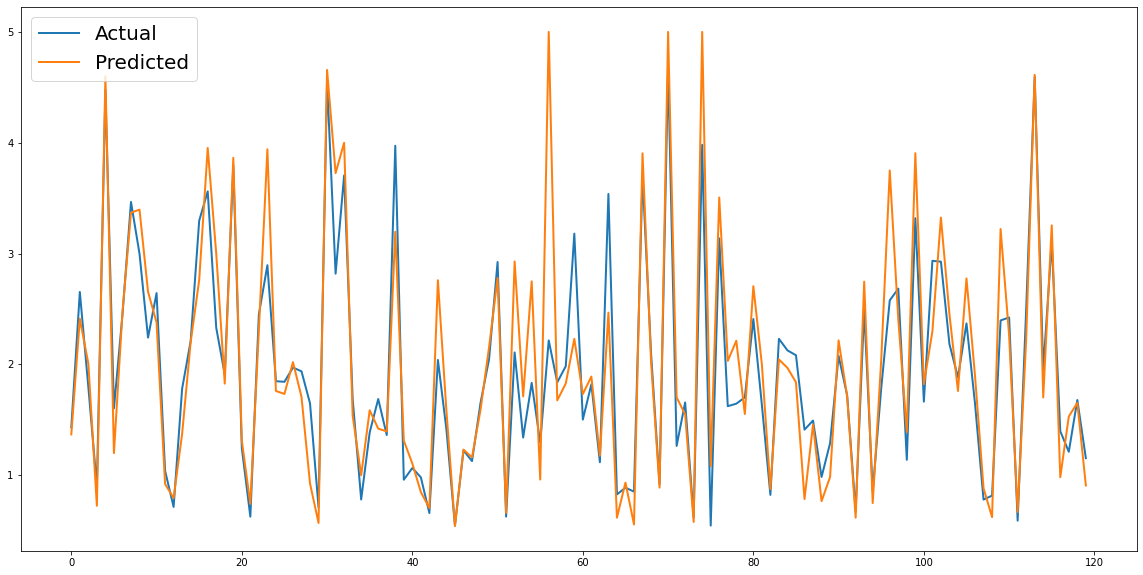

In [ ]:
#Graphical representation of predictions and truth
grp = pd.DataFrame({'prediction':y_pred,'Actual':y_test})
grp = grp.reset_index()
grp = grp.drop(['index'],axis=1)
plt.figure(figsize=(20,10))
plt.plot(grp[:120],linewidth=2)
plt.legend(['Actual','Predicted'],prop={'size': 20})

In [ ]:
#save AAE
n = range(0, 200)
test_error = []
train_error = []
count = 0
for item in n:
  xg_reg = xgb.XGBRegressor(objective = 'reg:squarederror', learning_rate = 0.1, max_leaf_nodes = 6, n_estimators = item)
  xg_reg.fit(X_train,y_train)
  y_pred_test = xg_reg.predict(X_test)
  err = np.sum(abs(y_test - y_pred_test))/y_test.shape[0]
  test_error.append(err)
  y_pred_train = xg_reg.predict(X_train)
  err1 = np.sum(abs(y_train - y_pred_train))/y_train.shape[0]
  train_error.append(err1)
  print(count)
  count+=1


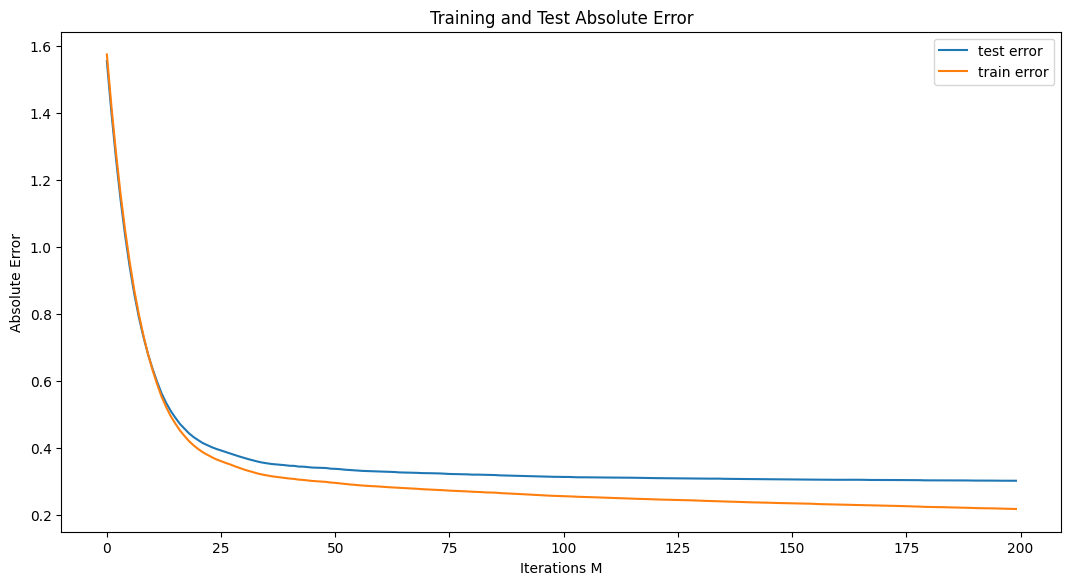

In [ ]:
#plot AAE
fig = plt.figure(1, figsize=(10, 5), frameon=False, dpi=100)
fig.add_axes([0, 0, 1, 1])
plt.plot(n, test_error, label = 'test error')
plt.plot(n, train_error, label = 'train error')
plt.xlabel("Iterations M")
plt.ylabel("Absolute Error")
plt.title("Training and Test Absolute Error")
plt.legend()
plt.show()


{'MedInc': 100.0, 'AveOccup': 39.434969425201416, 'Latitude': 31.88740611076355, 'HouseAge': 18.842768669128418, 'AveRooms': 10.534805804491043, 'Population': 7.578578591346741, 'AveBedrms': 6.4110927283763885}


Text(0.5, 0, 'Relative Importance')

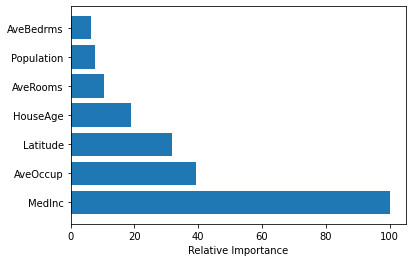

In [ ]:
#relative importance plot
feature_importance = xg_reg.feature_importances_
max = np.max(feature_importance)
relative_importance = []
rel_dict = {}
features = ["MedInc", "HouseAge", "AveRooms", "AveBedrms", "Population", "AveOccup", "Latitude", "Longitude"]
for item in feature_importance:
  rel = (item/max)*100
  relative_importance.append(rel)
for i in range(0,7):
  rel_dict[features[i]] = relative_importance[i]

rel_dict = sorted(rel_dict.items(), key=lambda x: x[1], reverse=True)
rel_dict = dict(rel_dict)
print(rel_dict)
y = list(rel_dict.values())
x = list(rel_dict.keys())

plt.barh(x, y)
plt.xlabel("Relative Importance")

[19:10:08] WARNING: /workspace/src/learner.cc:480: 
Parameters: { max_leaf_nodes } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




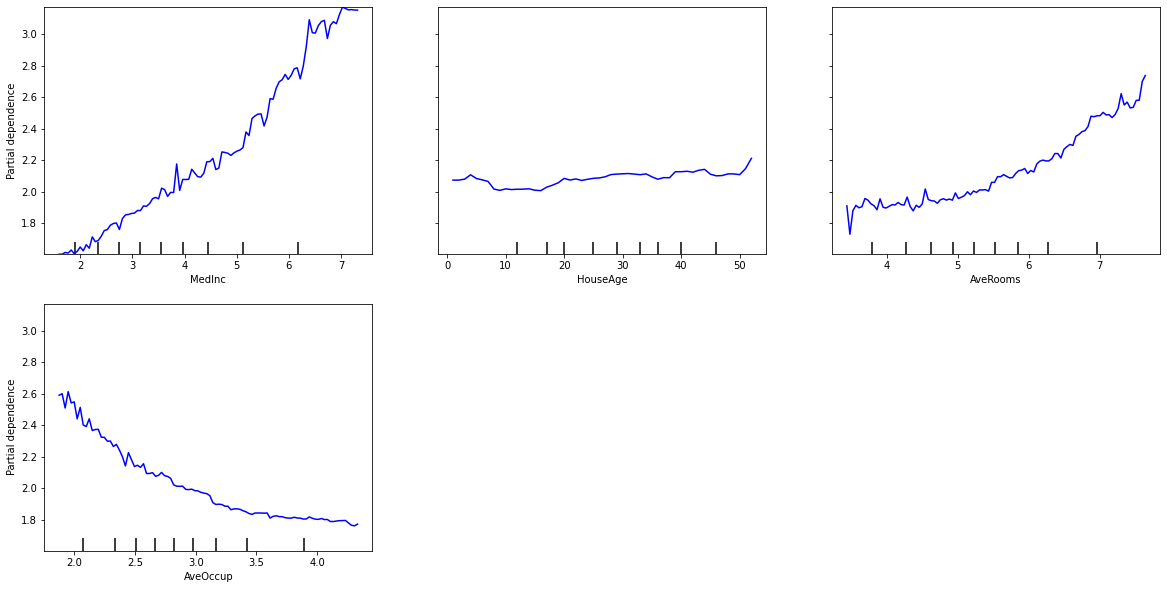

In [ ]:
#partial dependence plots
XGB_v=VotingRegressor([("reg",xg_reg)],).fit(X_train, y_train) #https://stackoverflow.com/questions/62627717/python-sklearn-notfittederror-after-xgboost-fit-has-been-called
feat=["MedInc", "HouseAge", "AveRooms", "AveOccup"]
fig, ax = plt.subplots(figsize=(20, 10))
XGB_RMR=PartialDependenceDisplay.from_estimator(XGB_v, X_train, feat, line_kw={"color": "blue"}, ax=ax)

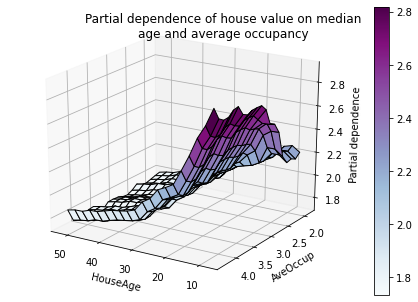

In [ ]:
#https://scikit-learn.org/0.22/auto_examples/inspection/plot_partial_dependence.html
#3D partial dependence plot using 2 features

fig = plt.figure()

XGB_v=VotingRegressor([("reg",xg_reg)],).fit(X_train, y_train)
features = ("AveOccup", "HouseAge")
pdp, axes = partial_dependence(XGB_v, X_train, features=features,
                               grid_resolution=20)
XX, YY = np.meshgrid(axes[1], axes[0])
Z = pdp[0].T
ax = Axes3D(fig)
surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1,
                       cmap=plt.cm.BuPu, edgecolor='k')
ax.set_xlabel(features[1])
ax.set_ylabel(features[0])
ax.set_zlabel('Partial dependence')
# init view
ax.view_init(elev=22, azim=122)
plt.colorbar(surf)
plt.suptitle('Partial dependence of house value on median\n'
             'age and average occupancy')
plt.subplots_adjust(top=0.9)

plt.show()

## **2. Covertype Data Set**

In [ ]:
#load data as pandas dataframe
#predict forest cover type
cov_type = fetch_covtype()
df = pd.DataFrame(cov_type.data, columns=cov_type.feature_names)
df['target'] = pd.Series(cov_type.target)
df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,target
0,2596.0,51.0,3.0,258.0,0.0,510.0,221.0,232.0,148.0,6279.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1,2590.0,56.0,2.0,212.0,-6.0,390.0,220.0,235.0,151.0,6225.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
2,2804.0,139.0,9.0,268.0,65.0,3180.0,234.0,238.0,135.0,6121.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,2785.0,155.0,18.0,242.0,118.0,3090.0,238.0,238.0,122.0,6211.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,2595.0,45.0,2.0,153.0,-1.0,391.0,220.0,234.0,150.0,6172.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5


In [ ]:
#check for null values
print(df.isnull().values.any())

False


In [ ]:
#split features and target
X = df[["Elevation", "Aspect", "Slope", "Horizontal_Distance_To_Hydrology", "Vertical_Distance_To_Hydrology", "Horizontal_Distance_To_Roadways", "Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm", "Horizontal_Distance_To_Fire_Points"]]
y = df["target"]

In [ ]:
print(X.shape)
print(y.shape)

(581012, 10)
(581012,)


In [ ]:
#split data into 80% training set and 20% test set
X_train2,X_test2,y_train2,y_test2 = train_test_split(X,y,test_size = 0.2, random_state=0)

In [ ]:
#initialize model
xg_class = xgb.XGBClassifier(objective = 'multi:softprob', learning_rate = 0.1, max_leaf_nodes = 6, n_estimators = 400)

#fit model
xg_class.fit(X_train2, y_train2)

#make predictions
y_pred2 = xg_class.predict(X_test2)

#accuracy
print(accuracy_score(y_test2, y_pred2))

0.761443336230562


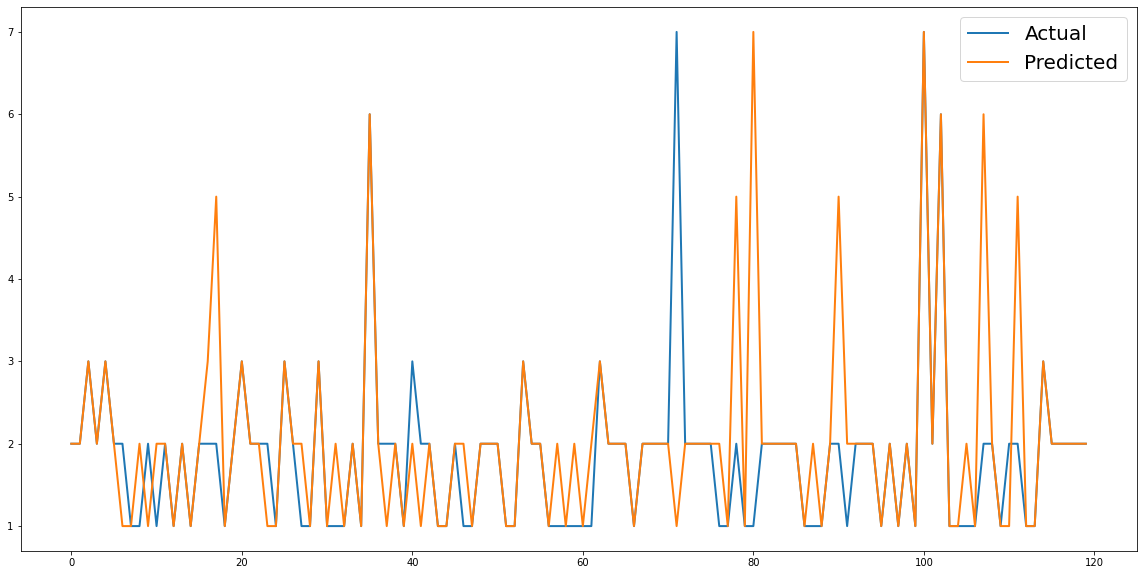

In [ ]:
#Graphical representation of predictions and truth
grp = pd.DataFrame({'prediction':y_pred2,'Actual':y_test2})
grp = grp.reset_index()
grp = grp.drop(['index'],axis=1)
plt.figure(figsize=(20,10))
plt.plot(grp[:120],linewidth=2)
plt.legend(['Actual','Predicted'],prop={'size': 20})

In [ ]:
#save AAE
n = range(0, 20)
test_error2 = []
train_error2 = []
for item in n:
  xg_class2 = xgb.XGBClassifier(objective = 'multi:softprob', learning_rate = 0.1, max_leaf_nodes = 6, n_estimators = item)
  xg_class2.fit(X_train2,y_train2)
  y_pred_test2 = xg_class2.predict(X_test2)
  err = np.sum(abs(y_test2 - y_pred_test2))/y_test2.shape[0]
  test_error2.append(err)
  y_pred_train2 = xg_class2.predict(X_train2)
  err1 = np.sum(abs(y_train2 - y_pred_train2))/y_train2.shape[0]
  train_error2.append(err1)

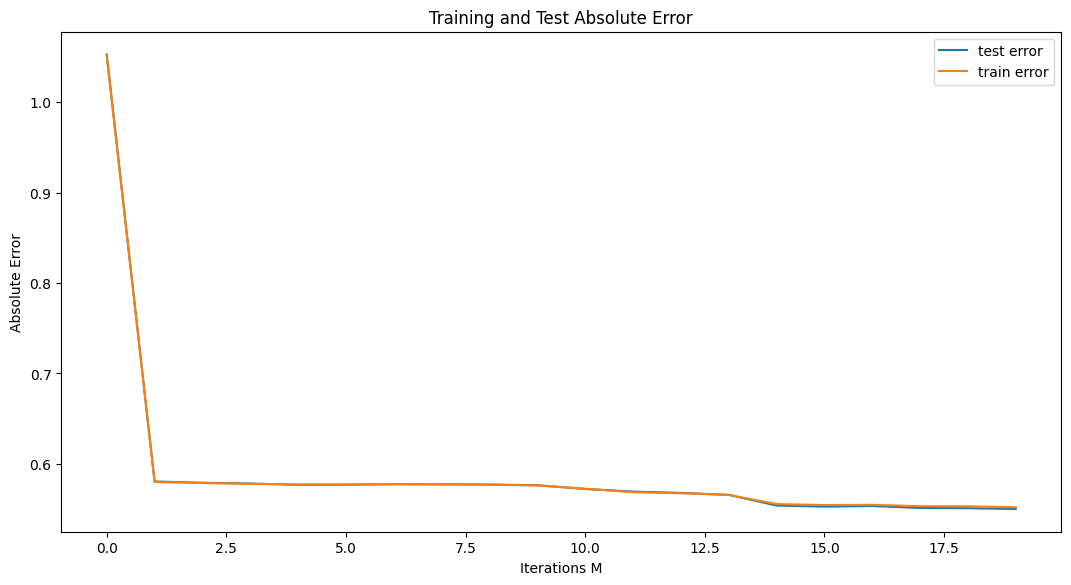

In [ ]:
#plot AAE
fig = plt.figure(1, figsize=(10, 5), frameon=False, dpi=100)
fig.add_axes([0, 0, 1, 1])
plt.plot(n, test_error2, label = 'test error')
plt.plot(n, train_error2, label = 'train error')
plt.xlabel("Iterations M")
plt.ylabel("Absolute Error")
plt.title("Training and Test Absolute Error")
plt.legend()
plt.show()


{'Elevation': 100.0, 'Horizontal_Distance_To_Hydrology': 21.032075583934784, 'Horizontal_Distance_To_Roadways': 15.256182849407196, 'Aspect': 14.724346995353699, 'Hillshade_9am': 12.220163643360138, 'Vertical_Distance_To_Hydrology': 9.158992767333984, 'Slope': 6.598029285669327}


Text(0.5, 0, 'Relative Importance')

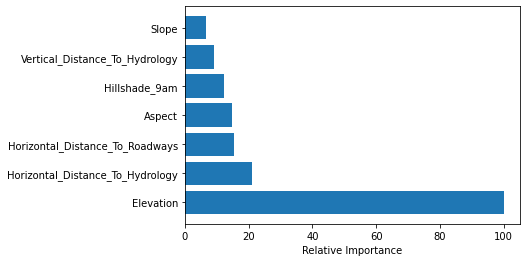

In [ ]:
#plot relative importances
feature_importance = xg_class.feature_importances_
max = np.max(feature_importance)
relative_importance = []
rel_dict = {}
features = ["Elevation", "Aspect", "Slope", "Horizontal_Distance_To_Hydrology", "Vertical_Distance_To_Hydrology", "Horizontal_Distance_To_Roadways", "Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm", "Horizontal_Distance_To_Fire_Points"]
for item in feature_importance:
  rel = (item/max)*100
  relative_importance.append(rel)
for i in range(0,7):
  rel_dict[features[i]] = relative_importance[i]

rel_dict = sorted(rel_dict.items(), key=lambda x: x[1], reverse=True)
rel_dict = dict(rel_dict)
print(rel_dict)
y = list(rel_dict.values())
x = list(rel_dict.keys())

plt.barh(x, y)
plt.xlabel("Relative Importance")

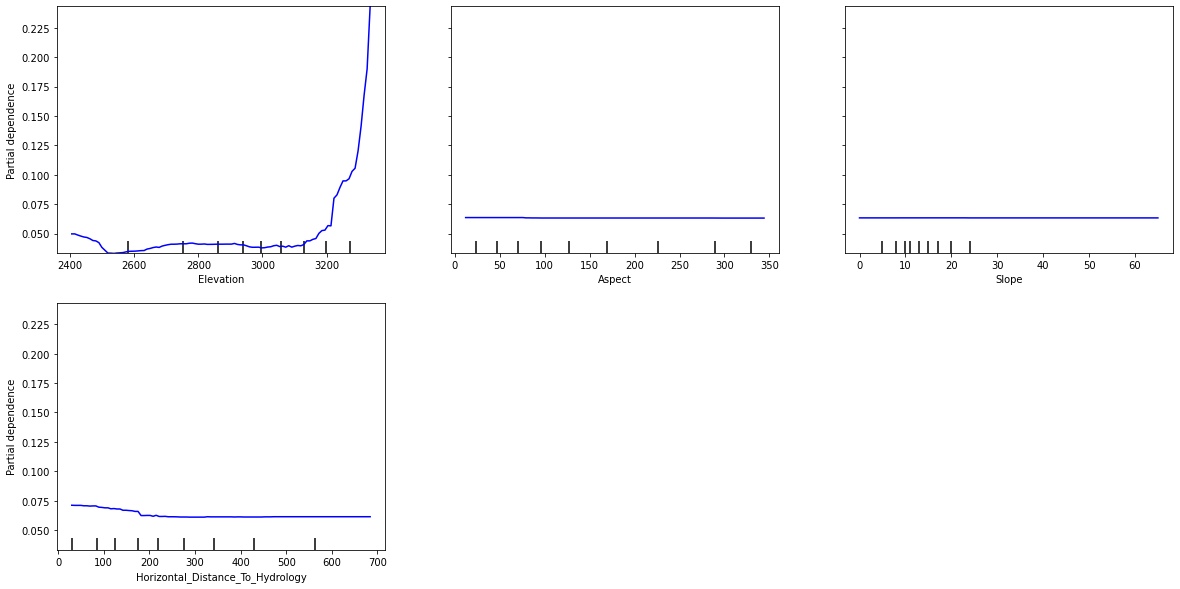

In [ ]:
#partial dependency plots
xg_class2 = xgb.XGBClassifier(objective = 'multi:softprob', learning_rate = 0.1, max_leaf_nodes = 6, n_estimators = 20)
xg_class2.fit(X_train2, y_train2)
fig, ax = plt.subplots(figsize=(20, 10))
features2 = ["Elevation", "Aspect", "Slope", "Horizontal_Distance_To_Hydrology"]
XGB_class=PartialDependenceDisplay.from_estimator(xg_class2, X_train2, features2, feature_names = features2, line_kw={"color": "blue"}, ax=ax, target=7)